# Image Classification with CNN using Keras

Import Libraries

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.8.2
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


Preprocess Data and choose subset of dataset




In [ ]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


Visualize Examples

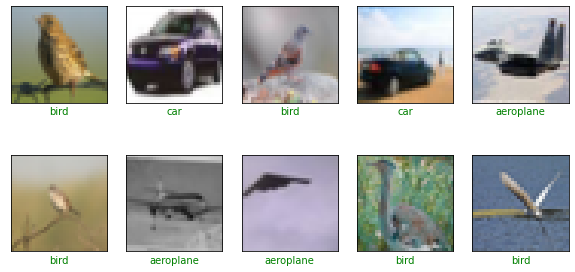

In [ ]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x,y, p):
  indices = np.random.choice(range(x.shape[0]), 10, replace = False)
  x = x[indices]
  y = y[indices]
  p = p[indices]

  plt.figure(figsize = (10,5))
  for i in range(10):
    plt.subplot(2,5, 1+i)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
    col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
    plt.xlabel(class_names[np.argmax(p[i])], color = col)
  plt.show()
show_random_examples(x_train, y_train, y_train)

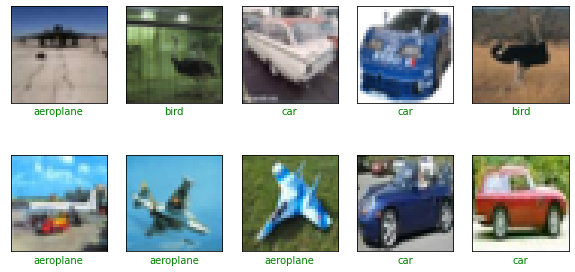

In [ ]:
show_random_examples(x_test, y_test, y_test)

Create Model

In [ ]:
from operator import add
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
  def add_conv_block(model, num_filters):
    model.add(Conv2D(num_filters, 3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(Conv2D(num_filters, 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(0.5))
    return model

  model = tf.keras.Sequential()
  model.add(Input(shape = (32,32,3)))
  model = add_conv_block(model, 32)
  model = add_conv_block(model, 64)
  model = add_conv_block(model, 128)

  model.add(Flatten())
  model.add(Dense(3, activation = 'softmax'))

  model.compile(
      loss = 'categorical_crossentropy',
      optimizer = 'adam',
      metrics = ['accuracy']
  )
  return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        1

Train the Model

In [ ]:
from gc import callbacks
h = model.fit(
    x_train/255., y_train, 
    validation_data=(x_test/255., y_test),
    epochs = 10, batch_size = 128,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only = True, save_weights_only = False,
            monitor= 'val_accuracy'
        
        
        )
    ]
)

Epoch 1/10
118/118 [==============================] - 89s 746ms/step - loss: 0.9198 - accuracy: 0.6728 - val_loss: 2.5496 - val_accuracy: 0.3333
Epoch 2/10
118/118 [==============================] - 91s 770ms/step - loss: 0.5538 - accuracy: 0.7795 - val_loss: 2.0375 - val_accuracy: 0.3863
Epoch 3/10
118/118 [==============================] - 90s 766ms/step - loss: 0.4948 - accuracy: 0.8014 - val_loss: 2.2360 - val_accuracy: 0.4687
Epoch 4/10
118/118 [==============================] - 89s 751ms/step - loss: 0.4586 - accuracy: 0.8192 - val_loss: 1.1171 - val_accuracy: 0.5953
Epoch 5/10
118/118 [==============================] - 89s 754ms/step - loss: 0.4132 - accuracy: 0.8385 - val_loss: 0.5295 - val_accuracy: 0.7830
Epoch 6/10
118/118 [==============================] - 89s 753ms/step - loss: 0.3917 - accuracy: 0.8481 - val_loss: 0.5947 - val_accuracy: 0.7887
Epoch 7/10
118/118 [==============================] - 88s 744ms/step - loss: 0.3597 - accuracy: 0.8585 - val_loss: 0.3793 - val_ac

 Final Predictions

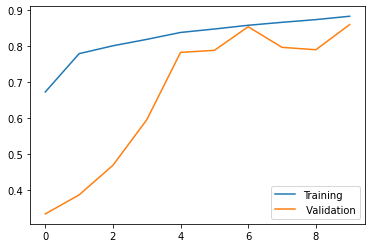

In [ ]:
accuracies = h.history['accuracy']
val_accuracies = h.history['val_accuracy']

plt.plot(range(len(accuracies)), accuracies, label = 'Training')
plt.plot(range(len(val_accuracies)), val_accuracies, label= ' Validation')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/models/model_0.860.h5')

In [ ]:
predictions = model.predict(x_test/255.)

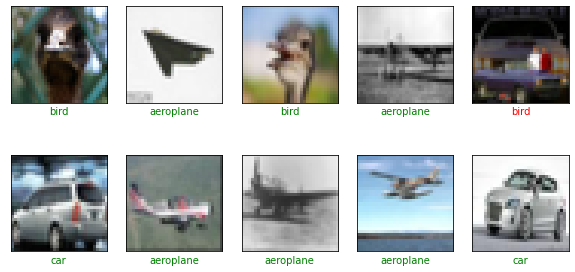

In [ ]:
show_random_examples(x_test, y_test, predictions)